In [87]:
%load_ext autoreload
%autoreload 2

import pandas as pd
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor, DistanceMetric
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import cross_val_score, GroupKFold
from sklearn.metrics import r2_score
from sklearn.externals import joblib
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import DBSCAN
from ml_utils import graph
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import collections
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np
import plotly.plotly as py
import plotly.graph_objs as go 

init_notebook_mode(connected=True)

%pylab inline
pylab.rcParams['figure.figsize'] = (15,9)

out_dir = '~/ftb/papi_output/speedup/'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3/dist-packages/IPython/core/magics/pylab.py:161: UserWarning:

pylab import has clobbered these variables: ['clf', 'plot']
`%matplotlib` prevents importing * from pylab and numpy



In [4]:
def aggregate(df):
    return df.groupby(['alg','run'])[df.columns[2:]].min()

def remove_outliers(x, y, df):
    xs = RobustScaler().fit_transform(x)
    
    db = DBSCAN(eps=1.9, min_samples=5, metric='chebyshev')
    cluster_labels = db.fit_predict(xs)
    x2 = [xi for cl, xi in zip(cluster_labels, x) if cl != -1]
    y2 = [yi for cl, yi in zip(cluster_labels, y) if cl != -1]
    df = df.drop(df.index[[i for i, cl in enumerate(cluster_labels) if cl == -1]])
    print('\t', len(x)-len(x2), 'outliers removed')
    return np.array(x2), np.array(y2), df

In [5]:
def best_neigh(x, y, df, pca_range, neigh_range):
    best = -inf
    best_n = (None, None)
    best_clf = (None, None)

    for n_comp in pca_range:
        for n_neigh in neigh_range:
            pca = PCA(n_components=n_comp)
            pca.fit(x)
            x2 = pca.transform(x)
            x2_test = x2
            y2_test = y
            #x2, y2, df2 = remove_outliers(x2, y, df)
            y2=y
            
            neigh = KNeighborsRegressor(n_neighbors=n_neigh, weights='distance')
            neigh.fit(x2, y2)
            
            groups = list(df.index.get_level_values(0))
            
            cv=GroupKFold(n_splits=3).split(x2_test, y2_test, groups)
            score = cross_val_score(neigh, x2_test, y2_test, cv=cv).mean()
            print(n_comp, '\t', n_neigh, '\t', round(score, 2))
            
            if score > best:
                best = score
                best_n = (n_comp, n_neigh)
                best_clf = (pca, neigh)
                
    print('--------------')
    print('PCA:\t', best_n[0])
    print('kNN:\t', best_n[1])
    print('Score:\t', best)
    return best_clf, x2

In [150]:
def load_data(files, scaler=None):
    paths = [out_dir + p for p in files]

    dfs_O0 = [pd.read_csv(path + '_O0.csv', error_bad_lines=False) for path in paths]
    df_O0 = pd.concat(dfs_O0)
    df_O0['run'] = df_O0['run'].astype(str)  
    df_O0 = aggregate(df_O0)
    print(df_O0.shape)
    
    dfs_O3 = [pd.read_csv(path + '_O3.csv', error_bad_lines=False) for path in paths]
    df_O3 = pd.concat(dfs_O3)
    df_O3['run'] = df_O3['run'].astype(str)
    df_O3 = df_O3[['alg', 'run', 'time_O3']]
    df_O3 = aggregate(df_O3)
    print(df_O3.shape)
    
    df_meta = pd.read_csv('/home/maciej/ftb/kernels_lore/proc/metadata.csv', index_col='alg')
    
    df = df_O0.merge(df_O3, left_index=True, right_index=True)
    df['max_dim'] = df.index.get_level_values(0)
    df['max_dim'] = df['max_dim'].apply(lambda q: df_meta.loc[q]['max_dim'])
    df = df.loc[df['time_O3'] > 0]
    df = df.loc[df['max_dim'] == 2]
    
    for col in df.columns:
        if col[:4] == 'PAPI' and col != 'PAPI_TOT_INS':
            df[col] = df[col].astype(float).div(df['PAPI_TOT_INS'], axis=0)
    df['PAPI_TOT_INS'] = 1
    df = df.dropna()  
    
    df['speedup'] = df['time_O0'] / df['time_O3']

    cols = sorted(list(df.columns.values))
    df = df[cols]

    x = df.drop(['time_O0', 'time_O3', 'speedup', 'max_dim'],axis=1).values
    y = df['speedup'].values
    
    if scaler is None:
        scaler = RobustScaler(quantile_range=(10,90))
        #scaler = StandardScaler()
        x = scaler.fit_transform(x)
    else:
        x = scaler.transform(x)

    print(df.shape)
    
    return x, y, df, scaler

In [151]:
x, y, df, scaler = load_data(['o1', 'o2', 'o3', 'o4'])

(7446, 53)
(7441, 1)
(493, 56)


In [152]:
(pca, neigh), x2 = best_neigh(x, y, df, range(2, 15, 2), range(6, 20, 5))
clf = neigh

2 	 6 	 0.06
2 	 11 	 0.06
2 	 16 	 0.07
4 	 6 	 0.16
4 	 11 	 0.14
4 	 16 	 0.18
6 	 6 	 0.33
6 	 11 	 0.34
6 	 16 	 0.37
8 	 6 	 0.29
8 	 11 	 0.33
8 	 16 	 0.36
10 	 6 	 0.3
10 	 11 	 0.32
10 	 16 	 0.33
12 	 6 	 0.33
12 	 11 	 0.33
12 	 16 	 0.33
14 	 6 	 0.28
14 	 11 	 0.32
14 	 16 	 0.32
--------------
PCA:	 6
kNN:	 16
Score:	 0.3675633990778109


In [153]:
pca = PCA(n_components=3)
pca.fit(x)
x2 = pca.transform(x)

x_test = x2
y_test = y
df_test = df

x2, y, df = remove_outliers(x2, y, df)
pca.explained_variance_ratio_.sum()

	 11 outliers removed


0.9839425251964025

In [139]:
neigh = KNeighborsRegressor(n_neighbors=11, weights='distance')
neigh.fit(x2, y) 
clf = neigh

In [12]:
regr = RandomForestRegressor()
regr.fit(x2, y)
for col, imp in zip(df.columns, regr.feature_importances_):
    print(col, '\t', round(imp * 100, 2), '%')
clf = regr

PAPI_BR_CN 	 5.27 %
PAPI_BR_INS 	 11.8 %
PAPI_BR_MSP 	 8.27 %
PAPI_BR_NTK 	 2.4 %
PAPI_BR_PRC 	 0.83 %
PAPI_BR_TKN 	 12.94 %
PAPI_CA_CLN 	 0.89 %
PAPI_CA_ITV 	 5.42 %
PAPI_CA_SHR 	 1.64 %
PAPI_DP_OPS 	 3.0 %
PAPI_FDV_INS 	 6.16 %
PAPI_FML_INS 	 0.27 %
PAPI_FP_INS 	 2.56 %
PAPI_FP_OPS 	 3.3 %
PAPI_HW_INT 	 0.6 %
PAPI_L1_DCA 	 0.89 %
PAPI_L1_DCH 	 0.51 %
PAPI_L1_DCM 	 3.03 %
PAPI_L1_ICA 	 0.16 %
PAPI_L1_ICH 	 2.21 %
PAPI_L1_ICM 	 2.17 %
PAPI_L1_LDM 	 0.31 %
PAPI_L1_STM 	 0.6 %
PAPI_L1_TCA 	 0.9 %
PAPI_L1_TCM 	 1.02 %
PAPI_L2_DCA 	 0.88 %
PAPI_L2_DCM 	 0.64 %
PAPI_L2_DCR 	 0.29 %
PAPI_L2_DCW 	 0.3 %
PAPI_L2_ICA 	 1.84 %
PAPI_L2_ICH 	 3.59 %
PAPI_L2_ICM 	 0.38 %
PAPI_L2_LDM 	 4.27 %
PAPI_L2_STM 	 6.47 %
PAPI_L2_TCA 	 0.4 %
PAPI_L2_TCH 	 0.59 %
PAPI_L2_TCM 	 0.93 %
PAPI_L2_TCR 	 0.93 %
PAPI_L2_TCW 	 0.8 %
PAPI_LD_INS 	 0.15 %
PAPI_REF_CYC 	 0.4 %
PAPI_RES_STL 	 0.0 %
PAPI_SP_OPS 	 0.0 %
PAPI_SR_INS 	 0.0 %
PAPI_TLB_DM 	 0.0 %
PAPI_TLB_IM 	 0.0 %
PAPI_TOT_CYC 	 0.0 %
PAPI_TOT_IIS 	 0.0 %
PAP

In [9]:
model_path = '../lore/models/'
joblib.dump(scaler, model_path + 'scaler.pkl') 
joblib.dump(pca, model_path + 'pca.pkl')
joblib.dump(neigh, model_path + 'neigh.pkl') 

['../lore/models/neigh.pkl']

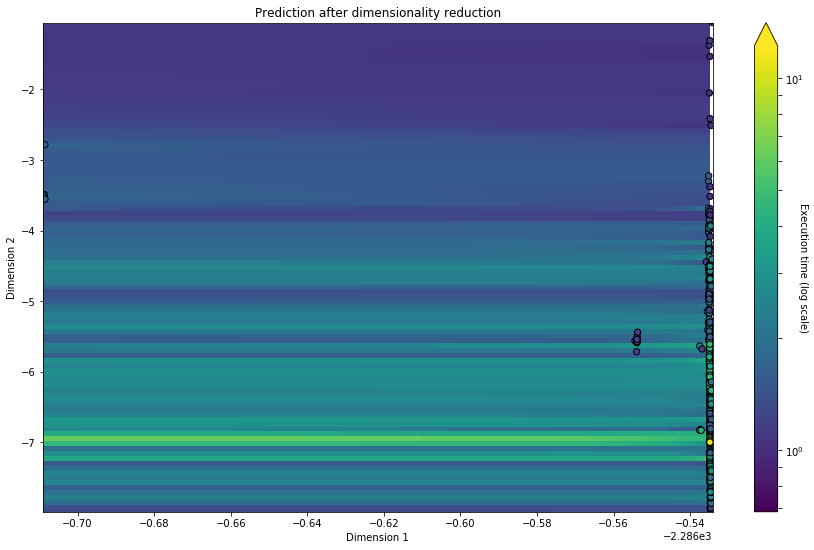

In [109]:
groups = list(df.index.get_level_values(0))
labels = [q.split('_')[-2][-2:] + q.split('_')[-1] for q in groups]
graph(clf, x2, y)
#graph(clf, x2, y, xlim=(-7.7,-4),ylim=(-3,-1), labels=labels)

In [154]:
labels = [q[-6:] for q in groups]

trace1 = go.Scatter(x=x2[:,0], y=x2[:,1], mode='markers', text=labels, hoverinfo='text',
                        marker = dict(size=8, color=[np.log(q) for q in y], line=dict(width=1, color='rgb(0, 0, 0)')))

layout = go.Layout(showlegend=False, hovermode='closest',
               yaxis=dict(zeroline=False, title='dim2'),
               xaxis=dict(zeroline=False, title='dim1'))

fig = go.Figure(data = [trace1], layout = layout)
iplot(fig, filename="c-v-predict")

In [155]:
trace1 = go.Scatter3d(x=x2[:,0], y=x2[:,1], z=x2[:,2], mode='markers', hoverinfo='none',
                        marker = dict(size=2, color=[np.log(q) for q in y], line=dict(width=1, color='rgb(0, 0, 0)')))

layout = go.Layout(showlegend=False,
               yaxis=dict(zeroline=False, title='dim2', ticks='', showticklabels=False),
               xaxis=dict(zeroline=False, title='dim1', ticks='', showticklabels=False))

fig = go.Figure(data = [trace1], layout = layout)
iplot(fig, filename="c-v-predict")

In [81]:
groups = list(df_test.index.get_level_values(0))

cv=GroupKFold(n_splits=3).split(x_test, y_test, groups)
cvres = list(cv)
group_names = [groups[q[1][0]] for q in cvres]

scores = cross_val_score(clf, x_test, y_test, cv=cvres)

scores.mean()

0.4297331936657168

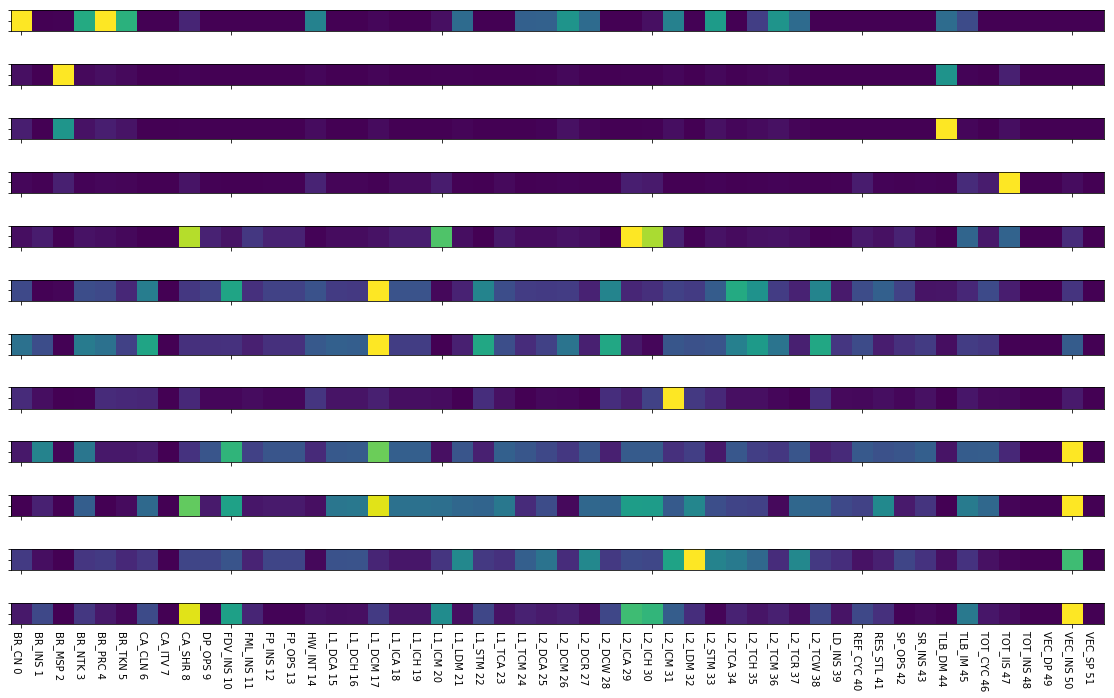

In [31]:
lab = df.columns[:52]

fig, axs = plt.subplots(nrows=pca.n_components)
for i, ax in enumerate(axs): 
    if i == pca.n_components - 1:
        for j, txt in enumerate(lab):
            ax.annotate('        '+txt[5:]+' '+str(j), (j-.5, 0), rotation=270)
    pcas = [abs(q) for q in pca.components_[i:i+1]]
    ax.imshow(pcas)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    
plt.tight_layout(pad=-1)
plt.show()

#for comp in pca.components_:
#    print([int(q * 100) for q in comp])